In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine) 

# reflect the tables
inspector = inspect(engine)

for table in inspector.get_table_names():
    columns = inspector.get_columns(table)
    print(f"Table: {table}")
    for column in columns:
        print(column["name"], column["type"])
    print()

Table: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Table: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(recent_date_str)

2017-08-23


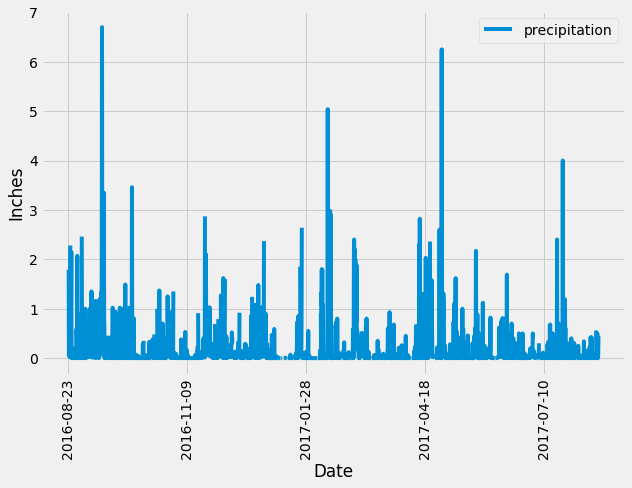

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime.strptime(recent_date_str, "%Y-%m-%d").date()

# Calculate the date one year from the last date in data set.
past_date = dt.datetime(year=recent_date.year - 1, month=recent_date.month, day=recent_date.day).date()

# Perform a query to retrieve the date and precipitation scores
sel = [Measurement.date, Measurement.prcp]
last_year_data = session.query(*sel)\
    .filter(Measurement.date >= past_date)\
    .filter(Measurement.date <= recent_date)\
    .all()

# All columns in Measurement are: ['id', 'station', 'date', 'prcp', 'tobs']
# We are picking only date and prcp.

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_year_data, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = df.plot(figsize=(9,7))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).count()

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count()]
stations_count = session.query(*sel)\
    .group_by(Measurement.station)\
    .order_by(func.count().desc())\
    .all()

stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = stations_count[0][0]

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .group_by(Measurement.station)\
    .all()

[(54.0, 85.0, 71.66378066378067)]

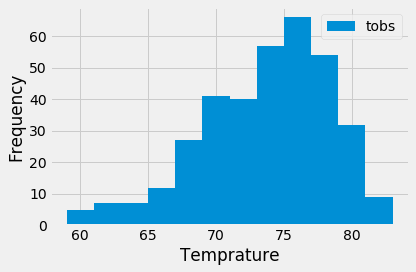

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent_date_str = session.query(Measurement.date)\
    .filter(Measurement.station == most_active_station)\
    .order_by(Measurement.date.desc())\
    .first()[0]
recent_date = dt.datetime.strptime(recent_date_str, "%Y-%m-%d").date()
past_date = dt.datetime(year=recent_date.year - 1, month=recent_date.month, day=recent_date.day).date()

sel = [Measurement.date, Measurement.tobs]
last_year_data = session.query(*sel)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= past_date)\
    .filter(Measurement.date <= recent_date)\
    .all()

df = pd.DataFrame(last_year_data, columns=['date', 'tobs'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.hist(bins=12)
plt.xlabel("Temprature")
plt.tight_layout()
plt.show()

# Close session

In [16]:
# Close Session
session.close()